**Authors**: Céline Hirsch, Sandra Frey, Sina Röllin

**Deep Learning Project**: Inclusiveness in Sarcasm Detection

# Audio Data Model for Embeddings

In [22]:
#Importing the necessary libraries
from functions_audio_model import *
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import zoom
import os
import json
import numpy as np
from torch.utils.data import Dataset

In [3]:
class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, labels):
        self.embedding_dir = embedding_dir
        self.file_list = [f for f in os.listdir(embedding_dir) if f.endswith('_w2V2.npy')]
        self.labels = labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file
        base_name = self.file_list[idx].replace('_w2V2.npy', '')

        embedding = np.load(os.path.join(self.embedding_dir, base_name + '_w2V2.npy'))
    
        #label
        label = self.labels[base_name]
        #embedding
        embedding = torch.mean(torch.from_numpy(embedding), dim=1)
        
        return embedding, label

In [ ]:
#Example Female Set

In [4]:
with open('data/audio/labels_F.json', 'r') as file:
    labelsF = json.load(file)

In [8]:
embeddings_dir = 'data/audio/embeddingsF/'

In [9]:
#HYPERPARAMETERS

batchsize = 8
learning_rate = 0.001
N_EPOCHS = 50

In [10]:
dataset = EmbeddingDataset(embeddings_dir, labelsF)

dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

In [14]:
#Classifier HEAD
class Classifier(nn.Module):
    def __init__(self, num_classes, in_features):
        super(Classifier, self).__init__()
        #Linear Layer
        self.linear = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [18]:
#Splitting the dataset into training, testing, and validation data

##### NEED TO ADJUST TO WHAT YOU CHOSE AS SPLITTING PERCENTAGES HERE

train_size = int(0.8 * len(dataset))  # 80% of the data for training
val_size = int(0.1 * len(dataset))    # 10% of the data for validation
test_size = len(dataset) - train_size - val_size   # Remaining data for testing (10%)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
val_dataloader = DataLoader(val_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

train Loss: 0.4063,  ACC: 0.7798, F1-weighted: 0.7508


100%|██████████| 3/3 [00:00<00:00, 58.86it/s]


eval Loss: 0.3696,  ACC: 0.8250, F1-weighted: 0.8126


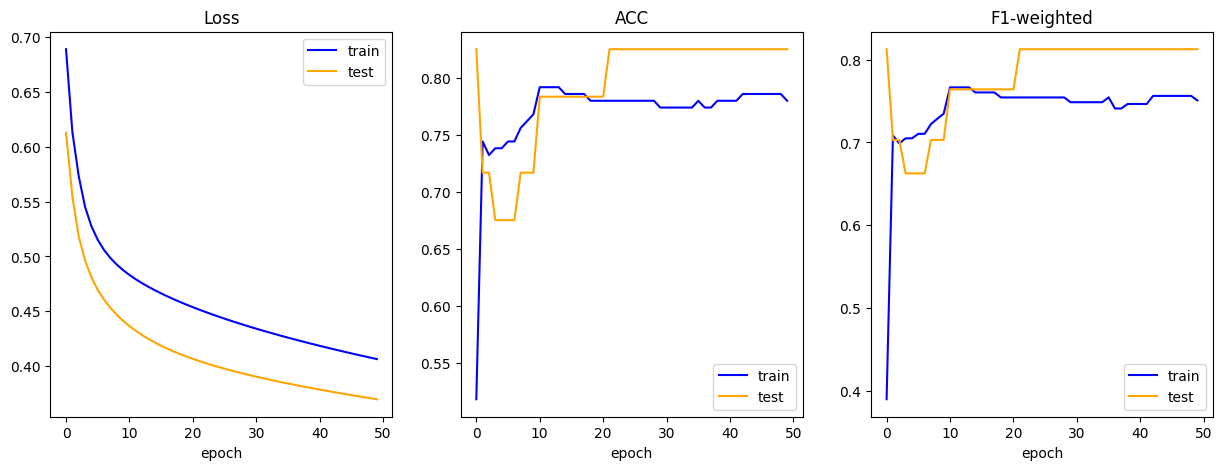

In [20]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

#Definition of the Model HEAD
#number of features of last layer Wav2Vec2
num_ftrs = 768

#Binary Classification -> Sarcasm or not
num_classes = 2 

model_head = Classifier(num_classes, num_ftrs)

# Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

# Train the model
train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model_head.state_dict(), results_models_weights_dir + 'audio_model_embeddings.pth')
